----
# 2KBot ETL EDA

*Author*: Rodrigo Valdelvira Ortigosa

----

<img src= "https://drive.google.com/uc?export=view&id=1PNdGDcUVw7GDeTIb72MvLYsJe3K7UR27" width="80%" height="80%">

## 1. Imports

In [41]:
## Dependencies
## =================================================================================================== ##

# pip install pymongo
# pip install dnspython
# pip install tensorflow
# pip install matplotlib
# pip install seaborn
# pip install tqdm
# pip install missingno
# pip install compound-word-splitter
# pip install pyenchant
# pip install langdetect
# pip install scikit-learn-intelex
# pip install scikit_optimize
# pip install scikit-plot
# pip install xgboost
# pip install unidecode
# pip install spacy
# pip install gensim
# python -m spacy download en_core_web_md
# python -m spacy download es_core_news_md

In [1]:
## General Imports
## =================================================================================================== ##

# MongoDB native 
from pymongo import MongoClient

# arrays
import numpy as np

# DataFrames
import pandas as pd

# missing data
import missingno as msno

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# json transformations
import json

# bar progress
from tqdm import tqdm
tqdm.pandas()

# concatenate lists
from itertools import chain

# warning ignore
import warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
## NLP Imports
## =================================================================================================== ##

# regular expressions
import re

# text normalizing 
import unidecode

# language detectation
from langdetect import detect

# split compound nouns (en)
import splitter

# word count
from collections import Counter

# spaCy api for NLP pre-processing
import spacy

# english
nlp_en = spacy.load('en_core_web_md', disable=['ner', 'parser'])

# spanish
nlp_es = spacy.load('es_core_news_md', disable=['ner', 'parser'])

In [3]:
# Tensorflow

from tensorflow.keras.models import load_model
from tensorflow.ragged import constant

## 2. Load Data

Fuctions for data loading from MongoDB: `users` & `companies`

In [4]:
## Database Conecction 
## =================================================================================================== ##

def get_users():
  
    host = '2kbot.dp2to.mongodb.net/users-linkedin-scraped?retryWrites=true&ssl=true&ssl_cert_reqs=CERT_NONE'
    user = 'users-linkedin-scraped'
    password = 'IsVSEzCPGhUJFQJe'
    uri = f'mongodb+srv://{user}:{password}@{host}'
    client = MongoClient(uri)

    db = client['users-linkedin-scraped']
    collection_employees = db.users.find()
    users = list(collection_employees)
    return users

def get_companies():

    host = '2kbot.dp2to.mongodb.net/users-linkedin-scraped?retryWrites=true&ssl=true&ssl_cert_reqs=CERT_NONE'
    user = 'users-linkedin-scraped'
    password = 'IsVSEzCPGhUJFQJe'
    uri = f'mongodb+srv://{user}:{password}@{host}'
    client = MongoClient(uri)

    db = client['users-linkedin-scraped']
    collection_companies = db.companies.find()
    companies = list(collection_companies)
    return companies

Load of necessary files:

* Spanish StopWords: Common words such as determinants, articles, prepositions, auxiliary verbs both raw and normalized data (está, esta).
* English StopWords: Common words such as determinants, articles, prepositions, auxiliary verbs both raw and normalized data (He's hes, woudn't woudnt...).
* Language dictionary: Languages taken from users database for better detection during data transformations.
* Users profiles: Load of users raw data through a DataFrame.
* Companies info: Load of companies raw data through a DataFrame.

StopWords source : [stopwords](https://github.com/6/stopwords-json)

In [5]:
## Data load
## =================================================================================================== ##

# spanish stopwords (list)
with open('database/es_stopwords.json', encoding='utf-8') as es_stopwords:
    es_stopwords = json.load(es_stopwords)['es_stopwords']
    
# english stopwords (list)
with open('database/en_stopwords.json', encoding='utf-8') as en_stopwords:
    en_stopwords = json.load(en_stopwords)['en_stopwords']

# languages dictionary
with open('database/languages.json', encoding='utf-8') as languages:
    languages_dict = json.load(languages)

# user profiles
raw_users_data = pd.DataFrame(get_users())
users_df = raw_users_data[['_id', 'occupation', 'experiences', 'education', 'languages', 'accomplishment_courses',
                     'certifications', 'headline', 'country', 'city', 'state']]

# company data
comps_df = pd.DataFrame(get_companies())

In [6]:
users_df.head(5)

,_id,occupation,experiences,education,languages,accomplishment_courses,certifications,headline,country,city,state
0,607800b0c5112c2802beb365,Creative Director at Apple Graphic Design,"[{'starts_at': {'day': None, 'month': None, 'y...","[{'starts_at': None, 'ends_at': None, 'field_o...",[],[],[],Creative Director at Apple,US,None,None
1,607800b0c5112c2802beb366,Co-Founder at Balio.app,"[{'starts_at': {'day': None, 'month': 3.0, 'ye...","[{'starts_at': {'day': None, 'month': None, 'y...","[English, Spanish, Catalan, French, Italian]",[],"[{'starts_at': {'day': None, 'month': 10.0, 'y...",Co-Founder Balio / Meller,ES,Barcelona,Cataluña
2,607800b0c5112c2802beb367,Head of International Logistics & Artwork Mana...,"[{'starts_at': {'day': None, 'month': 4.0, 'ye...","[{'starts_at': {'day': None, 'month': None, 'y...",[],[],[],Head International Logistics en Boehringer In...,ES,None,Barcelona y alrededores
3,607800b0c5112c2802beb368,Site Marketing & PR Specialist Getafe The Styl...,"[{'starts_at': {'day': None, 'month': 1.0, 'ye...","[{'starts_at': {'day': None, 'month': None, 'y...","[Ingles, Español]","[{'name': 'Atención al Cliente', 'number': '-'...","[{'starts_at': None, 'ends_at': None, 'url': N...",Marketing@Communication Coordinator/Trade Mark...,ES,Majadahonda,Community of Madrid
4,607800b0c5112c2802beb369,Responsable E-commerce at El Corte Ingles,"[{'starts_at': {'day': None, 'month': 5.0, 'ye...","[{'starts_at': None, 'ends_at': None, 'field_o...",[],[],[],Responsable E-commerce en El Corte Ingles,ES,None,None


In [7]:
comps_df.head(5)

,_id,linkedin_internal_id,description,website,industry,company_size,company_size_on_linkedin,hq,company_type,founded_year,...,tagline,universal_name_id,profile_pic_url,background_cover_image_url,funding_data,phone,search_id,similar_companies,follower_count,code
0,609a8edb9d86942da40af293,470073,3Net is dedicated to providing our customers t...,http://www.3netss.com,Information Technology and Services,"[11, 50]",3,"{'country': 'ES', 'geographic_area': None, 'ci...",PRIVATELY_HELD,NaN,...,None,3net-security-systems,https://media-exp1.licdn.com/dms/image/C4D0BAQ...,https://static-exp1.licdn.com/sc/h/5q92mjc5c51...,NaN,NaN,470073,"[{'name': 'Flexxible IT®', 'link': 'https://ww...",52.0,NaN
1,609a8edc9d86942da40af294,5163740,We’re one of the South West’s leading quality ...,http://www.aldermantooling.co.uk,Mechanical or Industrial Engineering,"[11, 50]",16,"{'country': 'GB', 'geographic_area': None, 'ci...",PUBLIC_COMPANY,1969.0,...,None,aldermans,https://media-exp1.licdn.com/dms/image/C4E0BAQ...,https://media-exp1.licdn.com/dms/image/C4E1BAQ...,NaN,NaN,5163740,"[{'name': 'The Barden Corporation UK', 'link':...",365.0,NaN
2,609a8ede9d86942da40af295,663901,Andorra Telecom is the company which exclusive...,http://www.andorratelecom.ad,Telecommunications,"[201, 500]",321,"{'country': 'AD', 'geographic_area': None, 'ci...",PUBLIC_COMPANY,1975.0,...,"Benvingut a Andorra Telecom, la companyia de c...",andorra-telecom_2,https://media-exp1.licdn.com/dms/image/C4E0BAQ...,https://media-exp1.licdn.com/dms/image/C4E1BAQ...,NaN,NaN,663901,"[{'name': 'Andorra', 'link': 'https://www.link...",3470.0,NaN
3,609a8ee69d86942da40af296,35626386,En Bull PerformanZe buscamos Info Productores ...,http://www.bullperformanze.com,Marketing and Advertising,"[11, 50]",12,"{'country': 'AD', 'geographic_area': None, 'ci...",SOLE_PROPRIETORSHIP,2019.0,...,Último Lanzamiento: Inversión en publicidad: 4...,bull-performanze,https://media-exp1.licdn.com/dms/image/C4E0BAQ...,https://media-exp1.licdn.com/dms/image/C4E1BAQ...,NaN,NaN,35626386,"[{'name': 'Instituto de Tráfico Online', 'link...",209.0,NaN
4,609a8ee79d86942da40af297,104778,La Cámara de Comercio e Industria de Madrid of...,http://www.camaramadrid.es,International Trade and Development,"[51, 200]",379,"{'country': 'ES', 'geographic_area': None, 'ci...",PUBLIC_COMPANY,1877.0,...,En Cámara Madrid encontrarás todo lo que neces...,c-mara-de-comercio-de-madrid,https://media-exp1.licdn.com/dms/image/C4D0BAQ...,https://media-exp1.licdn.com/dms/image/C4D1BAQ...,NaN,NaN,104778,"[{'name': 'Cámara de Comercio de España', 'lin...",22946.0,NaN


## 3. Text Cleaning

To get success with text models, string depuration is a must. To do so, functions below define how to proceed.

* `normalizing`: Define some rules through regular expressions.
* `clean_text`: This functions is able to distinguish between `es` or `en` text, remove stopwords and token lematizing. 

In [7]:
stopwords_es  = re.compile(r'\b(' + r'|'.join(es_stopwords) + r')\b\s*')
stopwords_en  = re.compile(r'\b(' + r'|'.join(en_stopwords) + r')\b\s*')
roman_numbers = re.compile(r'\b(?=[mdclxvii])m{0,4}(cm|cd|d?c{0,3})(xc|xl|l?x{0,3})([ii]x|[ii]v|v?[ii]{0,3})\b\.?')

def normalizing(text, company=False):
    text = re.sub(r'http\S+', '', text)                                               # remove http...
    text = re.sub(r'["“”.’;,:_/-]', ' ', text)                                        # replace .,;:...  by ' ' (eg: )
    if company:
        text = unidecode.unidecode(text.lower())                                      # text normalizing (no accents)
        text = stopwords_es.sub('', text)                                             # stop words spanish
        text = stopwords_en.sub('', text)                                             # stop words english
        text = re.sub(r'\W+', ' ', text)                                              # keep alphanumeric characters
        text = roman_numbers.sub('', text)                                            # remove roman numbers
    else:
        text = re.sub(r"[\[\]\\0-9()\"$#%/@;:<>{}`+='•■~|.!?,-]", '', text)           # keep alphabetic characters
    return ' '.join(text.split())                                                     # remove multiple whitespace

In [8]:
def clean_text(text, title=False):
    position = ['ADJ', 'ADV', 'NOUN', 'VERB']
    position.append('PROPN') if title else position
    text = normalizing(text)
    if detect(text) == 'es':
        doc_es = nlp_es(text)
        return [token.lemma_.lower() for token in doc_es if token.pos_ in position and token.text not in es_stopwords and len(token.text) >1]
    else:
        doc_en = [splitter.split(token) if len(token)>10 else [token] for token in text.split(' ')]
        doc_en = list(chain(*doc_en))
        doc_en = nlp_en(' '.join(doc_en))
        return [token.lemma_.lower() for token in doc_en if token.pos_ in position and token.text not in en_stopwords and len(token.text) >1]

In [50]:
clean_text('''
              I’ve been working as senior system engineer consultant
              for infrastructure projects. Many of the projects where
              I’ve worked have been based in messaging, monitoring,
              🌍collaboration and security. I did more than 40 ✘consulting
              •projects with different scopes and sizes.
          ''')

['work',
 'senior',
 'system',
 'engineer',
 'consultant',
 'infrastructure',
 'project',
 'many',
 'project',
 'work',
 'base',
 'message',
 'monitoring',
 'security',
 'project',
 'scope',
 'size']

In [51]:
clean_text('''
                Reportando al Director de Desarrollo  de Europa
                y a la Dirección de Desarrollo  Corporativo de EE.UU.
                asumí las siguientes responsabilidades como Development
                Assistant del C.C. Madrid Xanadú:Labores de asistente de
                alta Dirección en la 😉campaña de lanzamiento e •inauguración
                del Centro Comercial Madrid Xanadú.Relación, ♥️negociación y
                contratación de proveedores y servicios. Archivo de administración
                de documentación de proyectos a nivel internacional.RRPP III IX 25
            ''')

['reportar',
 'asumí',
 'siguiente',
 'responsabilidad',
 'asistente',
 'alto',
 'campaña',
 'lanzamiento',
 'inauguración',
 'contratación',
 'proveedor',
 'servicio',
 'administración',
 'documentación',
 'proyecto',
 'nivel',
 'internacional']

## 4. Company Analysis

We won't get in deep in this dataset as our target is to squeeze information from user profiles.

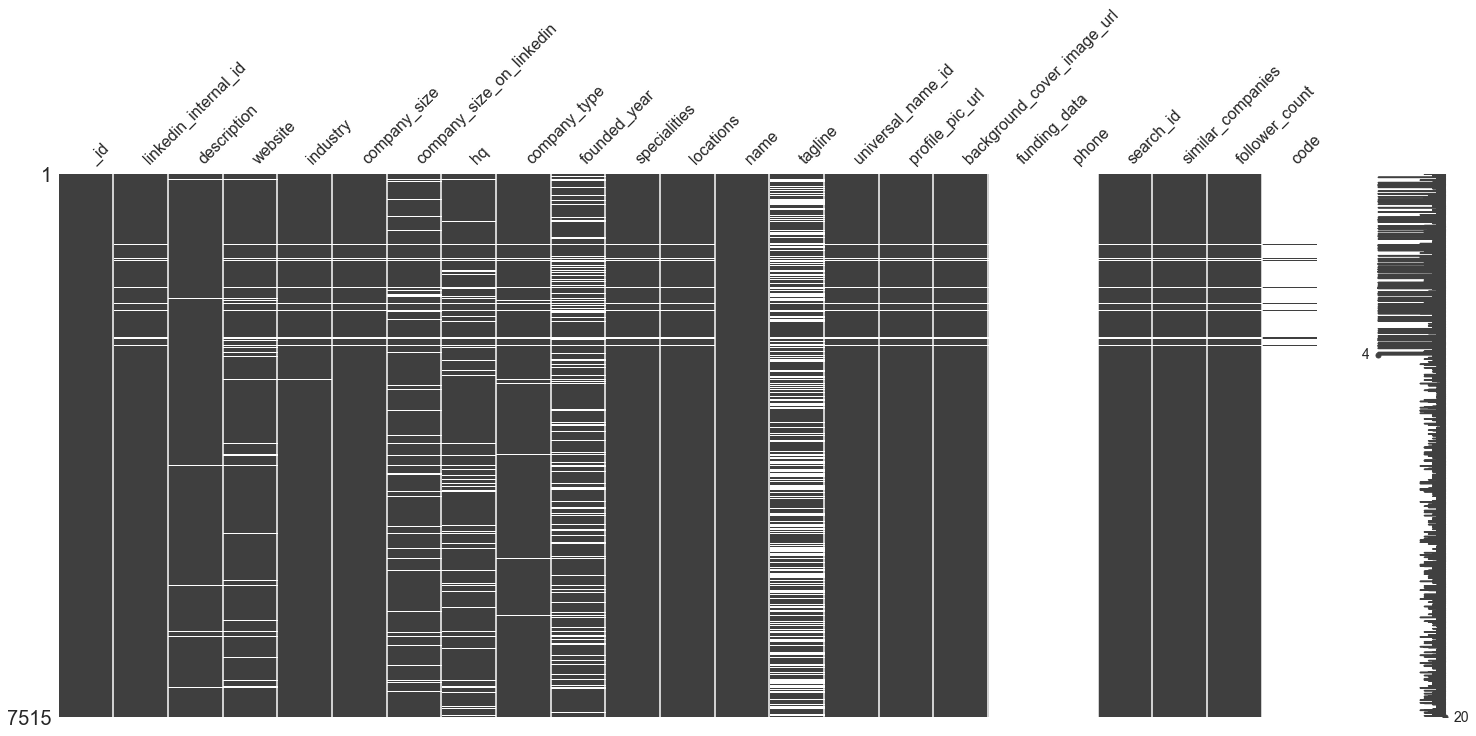

In [52]:
msno.matrix(comps_df);

In [9]:
comps_df['name_clean'] = comps_df['name'].apply(lambda name: normalizing(name, company=True) if isinstance(name, str) else '')
comps_df['_id_clean'] = comps_df['universal_name_id'].apply(lambda _id: normalizing(_id, company=True) if isinstance(_id, str) else '')

## 5. Users data transformation (Linkedin profiles preprocessing)

### 5.1 Languages Transformation

In [11]:
## Languages transformations
## =================================================================================================== ##

def clasif_lang(lang_dict, lang_list):
    languages = ''
    if lang_list and type(lang_list) is not float:
        try:
            for lang in lang_list:
                lang = lang.lower()
                if lang in lang_dict:
                    languages = languages + lang_dict[lang] + '|'
            return languages[:-1]
        except:
            print(lang_list)
            raise
    else:
        return None

users_df['languages'] = users_df['languages'].apply(lambda langs: clasif_lang(languages_dict, langs))

### 5.1 Education Transformation

This feaure will be study later.

In [12]:
## Education transformations
## =================================================================================================== ##

def certis(certs):
    resp = []
    for cert in certs:
        if cert:
            resp.append(cert['name'])
    if resp:
        return resp
    else:
        return None

users_df['studies'] = users_df['education'].apply(lambda education: education[0]['degree_name'] if education and type(education) == list else None)
users_df['university'] = users_df['education'].apply(lambda education: education[0]['school'] if education and type(education) == list else None)
users_df['certifications'] = users_df['certifications'].apply(lambda certifications: certis(certifications) if type(certifications) == list else None)
users_df['accomplishment_courses'] = users_df.apply(lambda row: certis(row.accomplishment_courses) if type(row.certifications) == list else None, axis=1)
users_df['number_experiences'] = users_df['experiences'].apply(lambda experiences: len(experiences) if experiences and type(experiences) == list else None)

users_df = users_df.drop('education', axis=1)
users_df.head(3)

,_id,occupation,experiences,languages,accomplishment_courses,certifications,headline,country,city,state,studies,university,number_experiences
0,607800b0c5112c2802beb365,Creative Director at Apple Graphic Design,"[{'starts_at': {'day': None, 'month': None, 'y...",None,None,None,Creative Director at Apple,US,None,None,Bachelor of Arts (BA),"University of California, Berkeley",10.0
1,607800b0c5112c2802beb366,Co-Founder at Balio.app,"[{'starts_at': {'day': None, 'month': 3.0, 'ye...",english|spanish|catalan|french|italian,None,"[Scrum: The Basics, Excel: Tracking Data Easil...",Co-Founder Balio / Meller,ES,Barcelona,Cataluña,Master of Science (MSc),ESADE Business School,7.0
2,607800b0c5112c2802beb367,Head of International Logistics & Artwork Mana...,"[{'starts_at': {'day': None, 'month': 4.0, 'ye...",None,None,None,Head International Logistics en Boehringer In...,ES,None,Barcelona y alrededores,MBA,ESIC Business & Marketing School,3.0


### 5.3 User Profiles EDA (Exploratory Data Analysis)

In [10]:
# Missing values
# ================================================================

# replace non-valid values designed by '?' to NaN.
users_df.replace('?', np.nan, inplace = True)

def missing_data(df):
    total   =  df.isnull().sum()
    percent = (df.isnull().sum().div(df.shape[0])*100).round(1)
    df_missing_data = pd.DataFrame(({'NaN': total, '%': percent, 'types': df.dtypes}))
    return df_missing_data

In [14]:
missing_data(users_df)

,NaN,%,types
_id,0,0.0,object
occupation,636,5.1,object
experiences,1,0.0,object
languages,7143,57.7,object
accomplishment_courses,11718,94.7,object
certifications,9581,77.5,object
headline,326,2.6,object
country,1,0.0,object
city,2990,24.2,object
state,3217,26.0,object


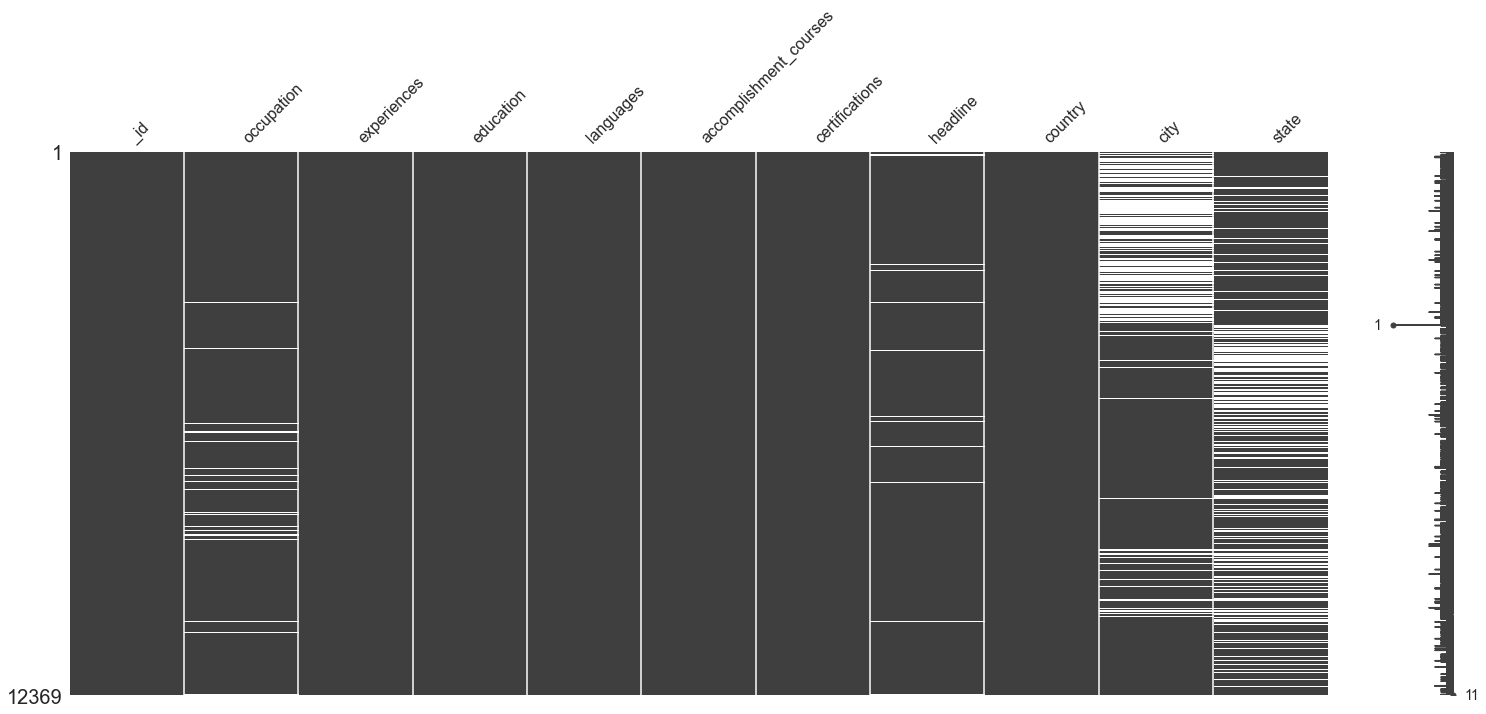

In [8]:
msno.matrix(users_df);

In [158]:
## Professional Experiences
## =================================================================================================== ##

pd.DataFrame(users_df['number_experiences'].value_counts()) \
  .head(10)

,number_experiences
1.0,1685
6.0,1208
5.0,1118
7.0,1103
8.0,1021
4.0,980
3.0,895
9.0,882
2.0,869
10.0,700


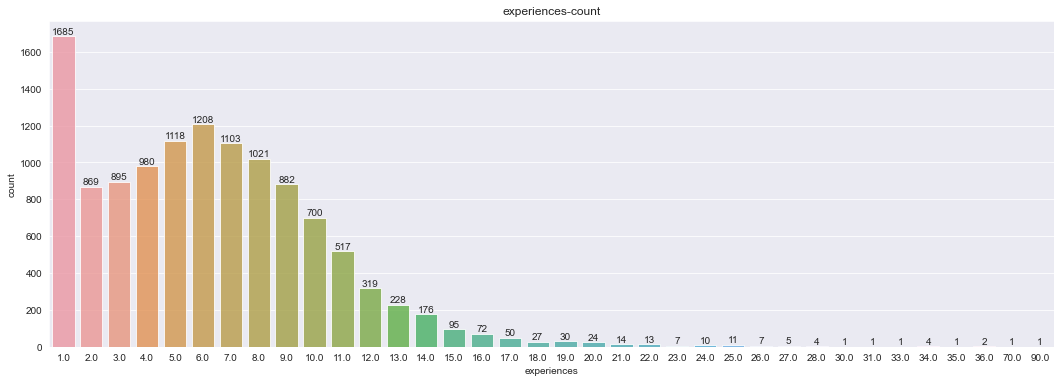

In [15]:
## Plot
## =================================================================================================== ##

categories = users_df['number_experiences'].value_counts().index
unique_values = users_df['number_experiences'].value_counts().values

plt.figure(figsize=(18, 6))
ax=sns.barplot(
    x=categories,
    y=unique_values,
    alpha=0.8
)
ax.bar_label(ax.containers[0])
plt.title('experiences-count')
plt.xlabel('experiences')
plt.ylabel('count');

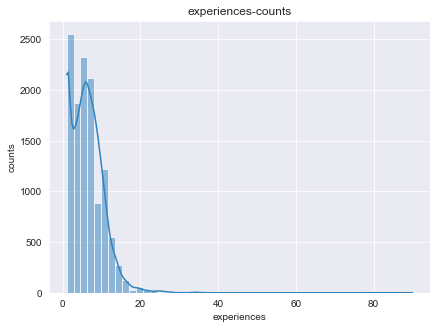

In [16]:
n_bins = 50

plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.histplot(data=users_df['number_experiences'], bins=n_bins, color="#3182bd", kde=True)
plt.title('experiences-counts')
plt.xlabel('experiences')
plt.ylabel('counts')
plt.xlim();

In [17]:
perc = 90

max = np.percentile(users_df['number_experiences'].dropna(), perc)
median = users_df['number_experiences'].median()

print(f'Percentile {perc}% of the number of experiences: {max:.0f} experiences. \nMeaning {perc}% of the users have had a maximun of {max:.0f} jobs.')
print(f'The median is: {median:.0f} jobs.')

Percentile 90% of the number of experiences: 11 experiences. 
Meaning 90% of the users have had a maximun of 11 jobs.
The median is: 6 jobs.


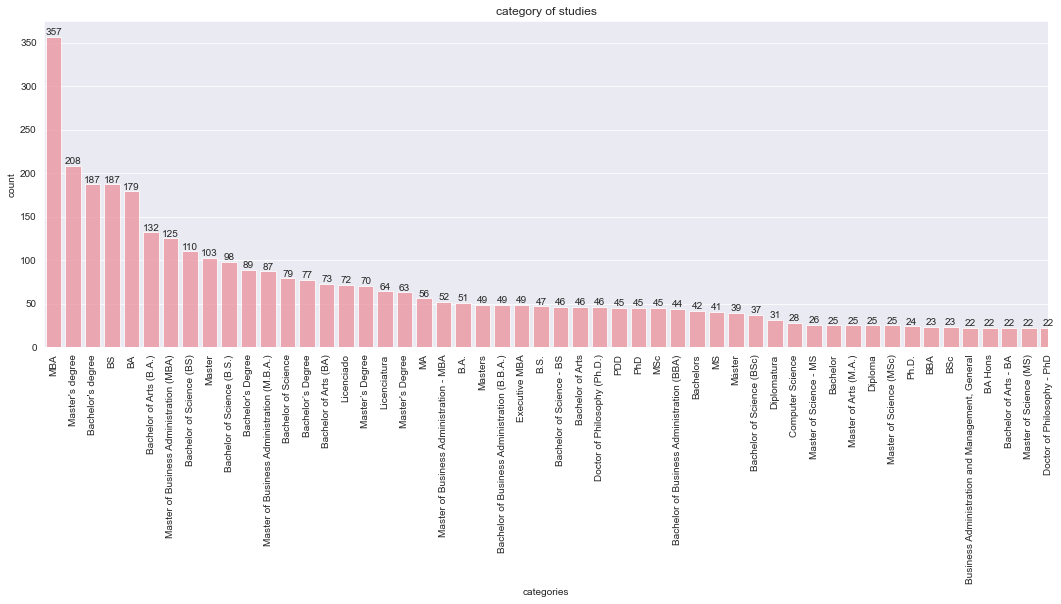

In [162]:
## Studies
## =================================================================================================== ##

categories = users_df['studies'].value_counts().index
unique_values = users_df['studies'].value_counts().values

plt.figure(figsize=(18, 6))
ax=sns.barplot(
    x=categories,
    y=unique_values,
    alpha=0.8
)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90, fontsize=10)
plt.title('category of studies')
plt.xlabel('categories')
plt.ylabel('count')
plt.xlim(-0.5, 51);

In [18]:
## Languages
## =================================================================================================== ##

data = users_df['languages'].str.get_dummies(sep= '|') 
data = data.apply(data.value_counts) \
  .T \
  .loc[:, [1]] \
  .sort_values(by=[1], ascending=False) \
  .set_axis(['users'], axis=1)

data['percentage %'] = round(data.div(users_df.shape[0])*100, 1)
data.head(10)

,users,percentage %
spanish,3324,26.9
english,2912,23.5
french,1019,8.2
italian,582,4.7
german,432,3.5
catalan,406,3.3
portuguese,290,2.3
russian,147,1.2
hindi,88,0.7
chinese,88,0.7


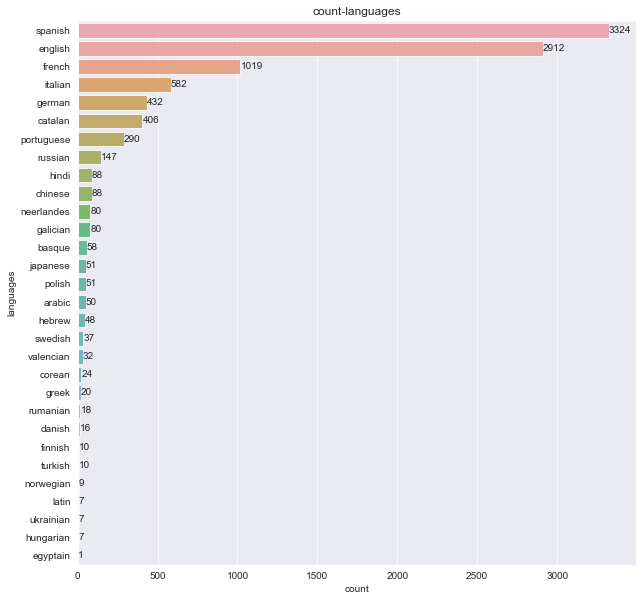

In [19]:
categories = data.index
unique_values = data['users']

plt.figure(figsize=(10, 10))
ax = sns.barplot(
    x=unique_values,
    y=categories,
    alpha=0.8
)
ax.bar_label(ax.containers[0])
plt.title('count-languages')
plt.xlabel('count')
plt.ylabel('languages');

* The most spoken languages are: `english`, `spanish` and below them we can consider `french`, `italian`, `german`, `catalan`, and `portuguese` as relevant.

## 6. Professional Experience Transformation

### 6.1 Transformations

This section is focused on creating a new dataset based on experiences informations as follows:

* `user`: id.
* `job_description`: Content the text transformation gathering both `title` & `description` 
* `language`: Shows `en` or `es` for job with title and descriptions as they're the ones shedding more info. for language detection (other languages are not reflected). 

In [21]:
def find_duration(experience):
    try:
        year = experience['starts_at']['year']
        if not experience['starts_at']['month']:
            month = 0
        else:
            month = experience['starts_at']['month']
        if not experience['ends_at']:
            year_end = time.gmtime().tm_year
            month_end = time.gmtime().tm_mon
        else:
            year_end = experience['ends_at']['year']
            if not experience['ends_at']['month']:
                month_end = 0
            else:
                month_end = experience['ends_at']['month']
        return (year_end - year) * 12 + (month_end - month)
    except:
        return None

    
def search_industry(company):
    try:
        company = normalizing(company, company=True).split(' ')
        for i, row in comps_df.iterrows():
            j=0
            for word in company:
                if re.search(word, row.name_clean):
                    j+=1
            if j/len(company) >= len(company)*0.2:
                return row.industry
            else:
                j=0
                for word in company:
                    if re.search(word, row._id_clean):
                        j+=1
                if j/len(company) >= len(company)*0.2:
                    return row.industry
    except:
        return None

def merging(title, description):
    try:
        if description != None:
            return clean_text(title, title=True) + clean_text(description)
        else:
            return clean_text(title, title=True)
    except:
        return None

def language_detection(title, description):
    if description !=None:
        return detect(title + ' ' + description)
    else:
        return None

experiences = pd.DataFrame()
#for i, row in tqdm(users_df.iterrows(), total=users_df.shape[0]):
    if type(row['experiences']) == list and len(row['experiences']) > 0:
        temp_df = pd.DataFrame(row['experiences'])
        temp_df['user']            = np.full(len(row['experiences']), str(row['_id']))
        temp_df['job_description'] = temp_df.apply(lambda row: merging(row.title, row.description), axis=1)
        temp_df['language']        = temp_df.apply(lambda row: language_detection(row.title, row.description), axis=1)
        temp_df['months']          = temp_df.apply(lambda row: find_duration(row), axis=1)
        temp_df['industry']        = temp_df['company'].apply(search_industry)
        temp_df                    = temp_df[['user', 'title', 'company', 'description', 'job_description', 'language', 'months', 'industry']]

        experiences = pd.concat([experiences, temp_df], axis=0)
        
experiences.head(5)

100%|██████████| 12369/12369 [9:32:55<00:00,  2.78s/it]  


,user,title,company,description,job_description,language,months,industry
0,607800b0c5112c2802beb365,Creative Director,Apple Graphic Design,None,"[creative, director]",None,195.0,Design
1,607800b0c5112c2802beb365,Creative Director,Apple Inc.,None,"[creative, director]",None,195.0,Consumer Electronics
2,607800b0c5112c2802beb365,Creative director,Apple Inc.,None,"[creative, director]",None,195.0,Consumer Electronics
3,607800b0c5112c2802beb365,Creative Director,Downtown Partners,None,"[creative, director]",None,12.0,Venture Capital & Private Equity
4,607800b0c5112c2802beb365,Senior Copywriter,"Butler, Shine & Stern",None,"[senior, copywriter]",None,36.0,None


Save & Load data

In [123]:
## Exporting Experiences csv & JSON format
## =================================================================================================== ##

experiences.to_csv('experiences.csv', encoding='utf-8-sig', sep=';')

experiences_dict = experiences.to_dict('list')
with open('database/experiences.json', 'w',  encoding='utf-8') as f:
    json.dump(experiences_dict, f, ensure_ascii=False, indent=4)

In [26]:
experiences = pd.read_csv('database/experiences.csv', encoding='utf-8-sig', sep=';') \
    .drop('Unnamed: 0', axis=1)

experiences['job_description'] = experiences['job_description'].apply(lambda x: eval(x) if not isinstance(x, float) else x)
experiences.head(5)

,user,title,company,description,job_description,language,months,industry
0,6185072c5d32022d581049ca,Ass't Vice President /Sales Manager,Webster Bank,NaN,"[ass't, vice, president, sales, manager]",NaN,46.0,Financial Services
1,60799ff2bec58756ba89fd66,Int'l Business Development,AZUD,Apoyo general al departamento de marketing e i...,"[int'l, business, development, departamento, m...",es,7.0,Renewables & Environment
2,616e83d0359c411d19857e54,Int'l Business Development,AZUD,Apoyo general al departamento de marketing e i...,"[int'l, business, development, departamento, m...",es,7.0,Renewables & Environment
3,616e93f611b4ce2cba27a0e1,Int'l Business Development,AZUD,Apoyo general al departamento de marketing e i...,"[int'l, business, development, departamento, m...",es,7.0,Renewables & Environment
4,6183bbf5f9a961195353d32f,Int'l Business Development,AZUD,Apoyo general al departamento de marketing e i...,"[int'l, business, development, departamento, m...",es,7.0,Renewables & Environment


### 6.2 Expriences EDA (Exploratory Data Analysis)

In [29]:
missing_data(experiences)

,NaN,%,types
user,0,0.0,object
title,5,0.0,object
company,35,0.0,object
description,34208,45.1,object
job_description,121,0.2,object
language,34168,45.1,object
months,1169,1.5,float64
industry,28309,37.4,object


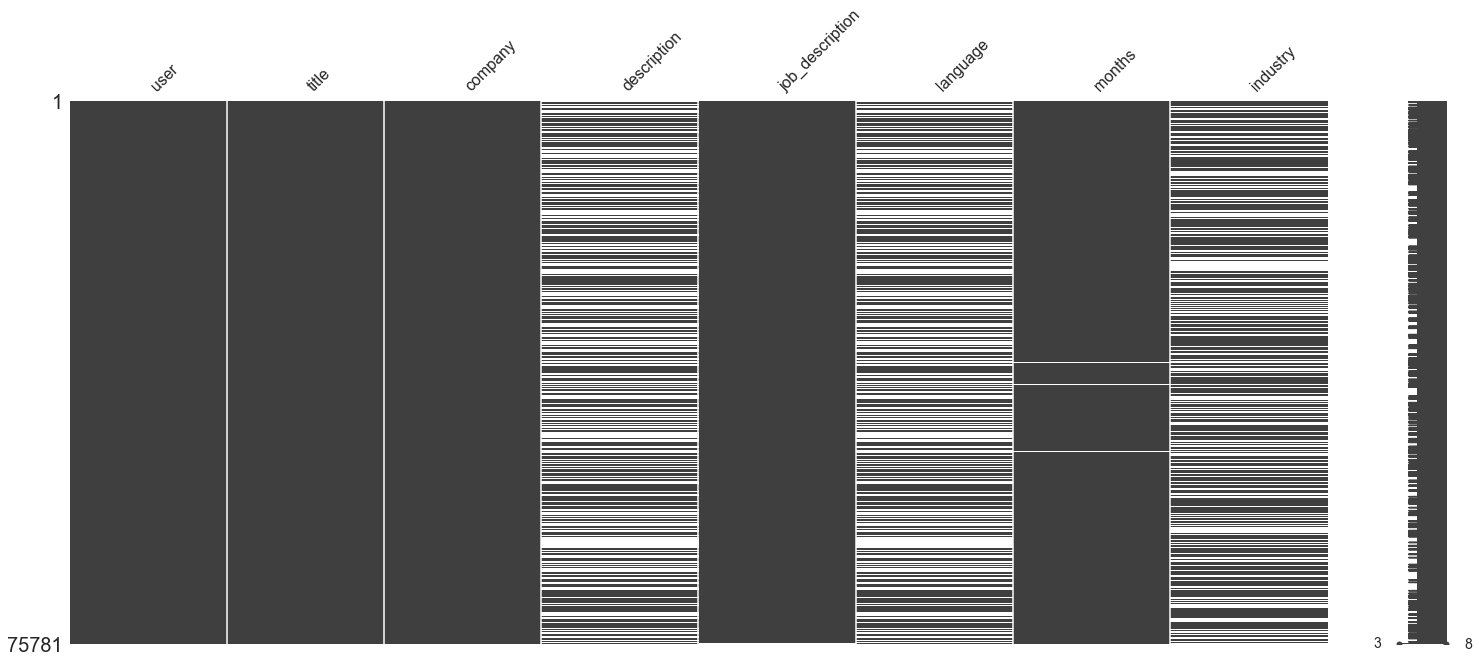

In [30]:
msno.matrix(experiences);

### 6.3 Industry Classification

Based on company industry the following graph shows a clear industry overview and the language distribution (en, es)

In [31]:
industries = len(experiences['industry'].value_counts())
print(f'there are {industries} industries')

there are 140 industries


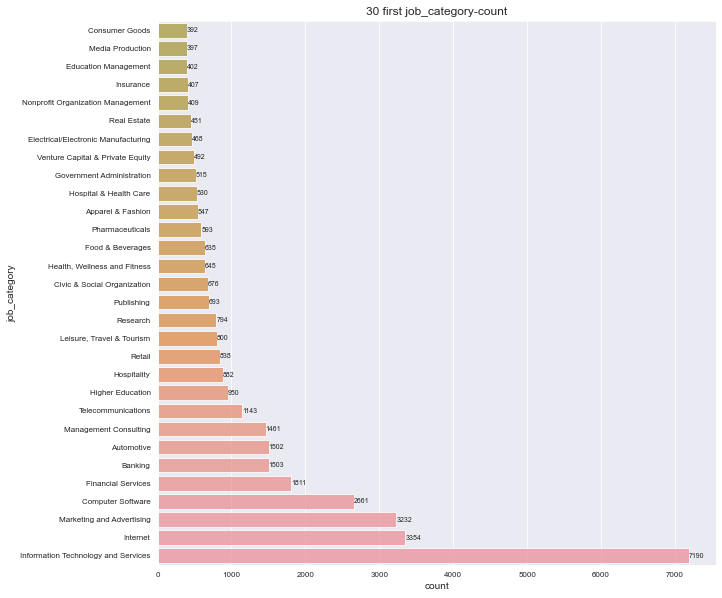

In [32]:
industries = experiences['industry'].value_counts().index.tolist()
count = experiences['industry'].value_counts().tolist()

plt.figure(figsize=(10, 10))
ax = sns.barplot(x=count, y=industries, alpha=0.8)
plt.bar_label(ax.containers[0], fontsize=7)
plt.title('30 first job_category-count')
plt.xlabel('count')
plt.ylabel('job_category')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);
plt.ylim(-0.5, 29.5);

In [33]:
industry_language = experiences.loc[(experiences['language'] == 'en') | (experiences['language'] == 'es'), ['industry', 'language', 'user']] \
    .groupby(['industry', 'language']) \
    .count() \
    .reset_index() \
    .sort_values(by='user', ascending=False)

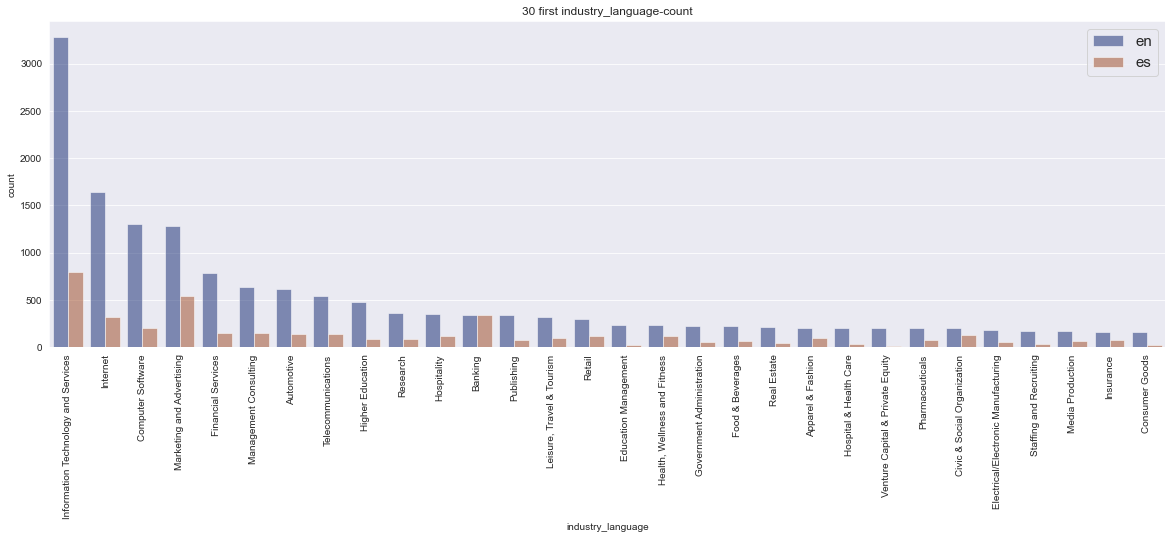

In [34]:
plt.figure(figsize=(20, 6))

ax = sns.barplot(
    data=industry_language,
    x='industry', y='user', hue='language',
    ci='sd', palette='dark', alpha=.5
)
plt.title('30 first industry_language-count')
plt.xlabel('industry_language')
plt.ylabel('count')
plt.legend(fontsize=15) 
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(-0.5, 29.5);

### 6.4 Word Frequency

Most common word in dataset

In [35]:
## Woud Count
## =================================================================================================== ##

# list of words in the dataset
words = experiences.loc[~experiences['job_description'].isnull(), 'job_description'].tolist()
words = list(chain(*words))

# word frequency
word_count = Counter(words)

# word frequency df
word_count_df = pd.DataFrame(list(word_count.values()), index=list(word_count.keys()), columns=['count']) \
    .sort_values(by='count', ascending=False)

word_count_df

,count
manager,16928
business,12750
marketing,12727
team,11881
development,10253
...,...
oceo,1
materiel,1
debarkation,1
barbara,1


In [36]:
print(f'Number of words in dataset: {len(words)} words')
print(f'Number of unique words in dataset: {len(word_count)} words')

Number of words in dataset: 1374875 words
Number of unique words in dataset: 31035 words


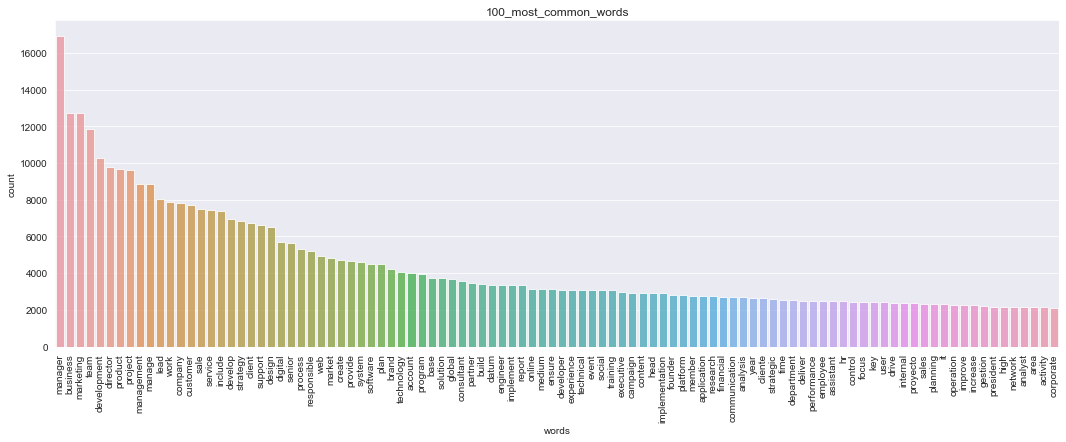

In [37]:
## Most Common Words
## =================================================================================================== ##

categories = word_count_df.index[0:100]
unique_values = word_count_df['count'].values[0:100]

plt.figure(figsize=(18, 6))
ax=sns.barplot(
    x=categories,
    y=unique_values,
    alpha=0.8
)
plt.xticks(rotation=90, fontsize=10)
plt.title('100_most_common_words')
plt.xlabel('words')
plt.ylabel('count');

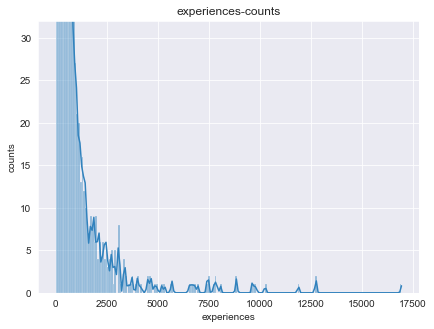

In [38]:
n_bins = 200

plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.histplot(data=word_count_df['count'], bins=n_bins, color="#3182bd", kde=True)
plt.title('experiences-counts')
plt.xlabel('experiences')
plt.ylabel('counts');
plt.ylim(0, 32);

In [39]:
#percentiles 25/50/75 & median
per_25 = np.percentile(word_count_df['count'].dropna(), 25)
per_50 = np.percentile(word_count_df['count'].dropna(), 50)
per_75 = np.percentile(word_count_df['count'].dropna(), 75)
per_85 = np.percentile(word_count_df['count'].dropna(), 85)
median = word_count_df['count'].median()

print(f'Percentile 25%: {per_25:.0f} times.') 
print(f'Percentile 50%: {per_50:.0f} times.') 
print(f'Percentile 75%: {per_75:.0f} times.')
print(f'Percentile 85%: {per_85:.0f} times.')
print(f'The median is: {median:.0f} times.')

Percentile 25%: 1 times.
Percentile 50%: 2 times.
Percentile 75%: 9 times.
Percentile 85%: 22 times.
The median is: 2 times.


We proceed to remove word below a frequency of two simplifiying and lightening this way the original tokenized texts.

In [42]:
# number of words 
word_count_short = word_count_df[word_count_df['count'] > per_50]
word_count_short_list = word_count_short.index.tolist()
word_count_short_list.remove('www')
word_count_short_list.remove('com')

print(f'Number of unique words after shortening: {len(word_count_short_list)} words')

Number of unique words after shortening: 14534 words


In [43]:
def shorten(text):
    text_short = []
    for word in text:
        if word in word_count_short_list:
            text_short.append(word)
    if len(text_short)>0:
        return text_short
    else:
        return None

experiences['job_description_short'] = experiences['job_description'].progress_apply(lambda text: shorten(text) if not isinstance(text, float) else text)

100%|██████████| 75781/75781 [00:29<00:00, 2564.32it/s]


Save data

In [44]:
experiences.to_csv('database/experiences_clean.csv', encoding='utf-8-sig', sep=';')

### 6.5 Job Category Manual Calssification

One of the most important features in this project is the `job_category` with which will be feed the recommender so the next step consists of designing a job_classifer that allows us to fillter the experiences as they come.
The first step is to classify manually the larger amount of jobs by cno (clasificación nacional de ocupaciones) criteria and subjective criteria according to job frequency.

Load Data (experiences)

In [42]:
experiences = pd.read_csv('database/experiences_clean.csv', sep=';', encoding='utf-8-sig') \
    .drop('Unnamed: 0', axis=1)

experiences['job_description_short'] = experiences['job_description_short'].apply(lambda x: eval(x) if not isinstance(x, float) else x)
experiences.head(5)

,user,title,company,description,job_description,language,months,industry,job_description_short
0,6185072c5d32022d581049ca,Ass't Vice President /Sales Manager,Webster Bank,NaN,"[""ass't"", 'vice', 'president', 'sales', 'manag...",NaN,46.0,Financial Services,"[vice, president, sales, manager]"
1,60799ff2bec58756ba89fd66,Int'l Business Development,AZUD,Apoyo general al departamento de marketing e i...,"[""int'l"", 'business', 'development', 'departam...",es,7.0,Renewables & Environment,"[int'l, business, development, departamento, m..."
2,616e83d0359c411d19857e54,Int'l Business Development,AZUD,Apoyo general al departamento de marketing e i...,"[""int'l"", 'business', 'development', 'departam...",es,7.0,Renewables & Environment,"[int'l, business, development, departamento, m..."
3,616e93f611b4ce2cba27a0e1,Int'l Business Development,AZUD,Apoyo general al departamento de marketing e i...,"[""int'l"", 'business', 'development', 'departam...",es,7.0,Renewables & Environment,"[int'l, business, development, departamento, m..."
4,6183bbf5f9a961195353d32f,Int'l Business Development,AZUD,Apoyo general al departamento de marketing e i...,"[""int'l"", 'business', 'development', 'departam...",es,7.0,Renewables & Environment,"[int'l, business, development, departamento, m..."


Load Data (manual categories)

In [49]:
titles = pd.read_csv('database/titles.csv', sep=';', encoding='utf-8-sig')
titles['job_category'].value_counts().to_frame()

,job_category
Emprendedores,847
"Analistas, programadores y diseñadores Web y multimedia",620
Project Managers,525
Coordinadores,424
"Escritores, periodistas y lingüistas",419
...,...
Analistas,1
Fisioterapeutas,1
Entrenadores deportivos,1
Consultores de publicidad,1


Merging both datasets

In [54]:
experiences_category = pd.merge(experiences, titles, on='title')

In [51]:
experiences_category.to_csv('database/experiences_category.csv', sep=';', encoding='utf-8-sig')

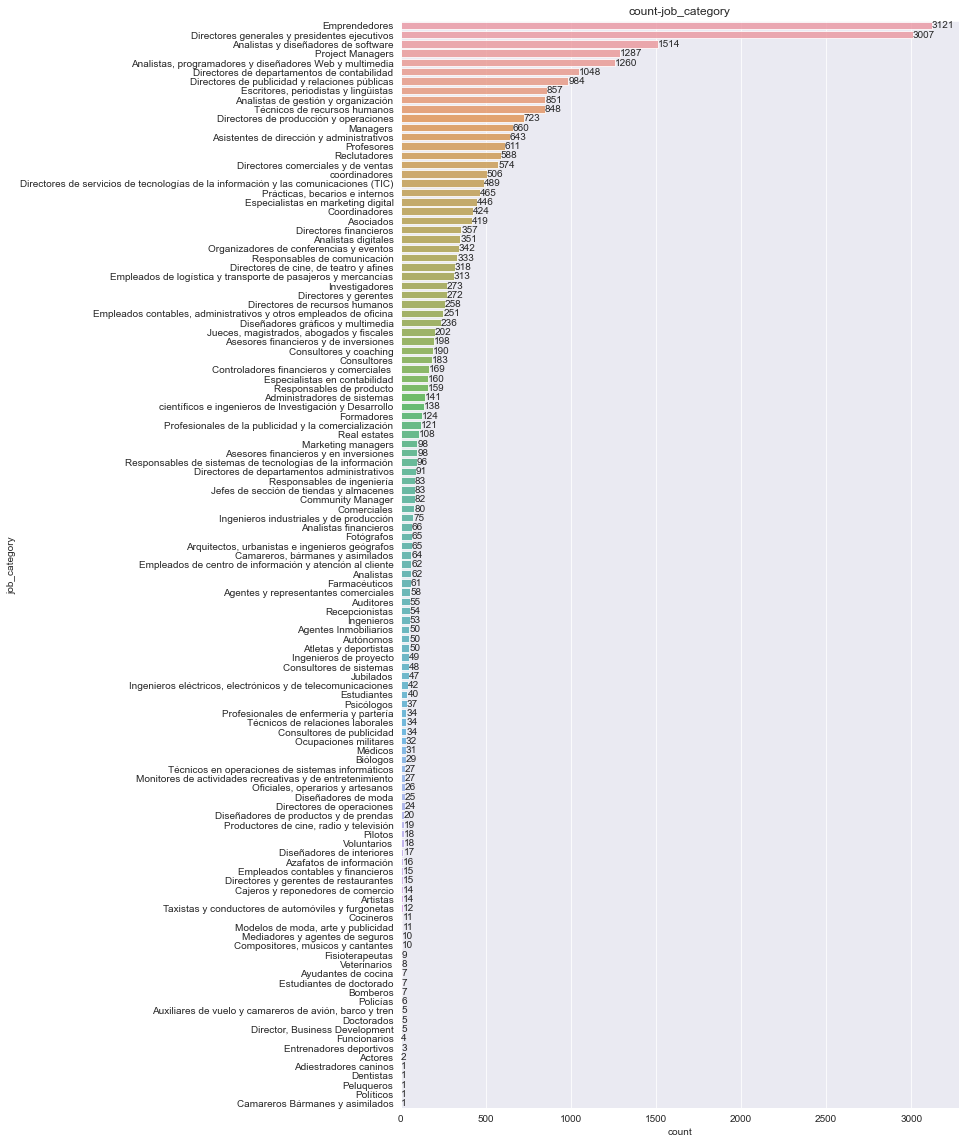

In [52]:
count = experiences_category['job_category'].value_counts().values
jobs = experiences_category['job_category'].value_counts().index

plt.figure(figsize=(10, 20))

ax = sns.barplot(y=jobs, x=count, alpha=0.8)
ax.bar_label(ax.containers[0])
plt.title('count-job_category')
plt.xlabel('count')
plt.ylabel('job_category')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

In [60]:
count = experiences_category[~experiences_category['job_category'].isnull()].shape[0]
print(f' The number of experiences categorized are: {count}')

 The number of experiences categorized are: 29002


### 6.6 Job Category Automatic Classification

After manual classification and model development, it'll be implemented so the unknown jobs are classified.

* Model development: see `classifier.ipynb`
* Choosen model: `RNN` train_accuracy: 94.9% - test_accuracy: 94.2% - categories: 88

In [4]:
# word-index dictionary
with open('database/word_index.json', encoding='utf-8') as word_index:
    word_index = json.load(word_index)
    
# index-category dictionary
with open('database/index_category.json', encoding='utf-8') as index_category:
    index_category = json.load(index_category)
    
rnn = load_model('models/word2vec/rnn.h5')

In [10]:
# Data

experiences = pd.read_csv('database/experiences_category.csv', sep=';', encoding='utf-8-sig').drop(['Unnamed: 0', 'count'], axis=1)
experiences['job_description_short'] = experiences['job_description_short'].apply(lambda x: eval(x) if not isinstance(x, float) else x)
experiences.head(5)

,user,title,company,description,job_description,language,months,industry,job_description_short,job_category
0,6185072c5d32022d581049ca,Ass't Vice President /Sales Manager,Webster Bank,NaN,"[""ass't"", 'vice', 'president', 'sales', 'manag...",NaN,46.0,Financial Services,"[vice, president, sales, manager]",NaN
1,60799ff2bec58756ba89fd66,Int'l Business Development,AZUD,Apoyo general al departamento de marketing e i...,"[""int'l"", 'business', 'development', 'departam...",es,7.0,Renewables & Environment,"[int'l, business, development, departamento, m...",NaN
2,616e83d0359c411d19857e54,Int'l Business Development,AZUD,Apoyo general al departamento de marketing e i...,"[""int'l"", 'business', 'development', 'departam...",es,7.0,Renewables & Environment,"[int'l, business, development, departamento, m...",NaN
3,616e93f611b4ce2cba27a0e1,Int'l Business Development,AZUD,Apoyo general al departamento de marketing e i...,"[""int'l"", 'business', 'development', 'departam...",es,7.0,Renewables & Environment,"[int'l, business, development, departamento, m...",NaN
4,6183bbf5f9a961195353d32f,Int'l Business Development,AZUD,Apoyo general al departamento de marketing e i...,"[""int'l"", 'business', 'development', 'departam...",es,7.0,Renewables & Environment,"[int'l, business, development, departamento, m...",NaN


Unknown data

In [64]:
unknown_category = experiences.loc[~experiences['job_category'].isin(index_category.values()) & ~experiences['job_description_short'].isnull()]
print(f'There are: {unknown_category.shape[0]} unknown elements')

There are: 46535 unknown elements


In [65]:
def word_to_num(description):
    description_num = []
    for word in description:
        if word in word_index.keys():
            description_num.append(word_index[word])
        else:
            continue
    return description_num

unknown_category['description_num'] = unknown_category['job_description_short'].apply(word_to_num)
unknown_category['description_num'][0:10]

0                                   [408, 288, 145, 1]
1    [4, 8, 229, 2, 513, 4293, 638, 513, 1687, 3124...
2    [4, 8, 229, 2, 513, 4293, 638, 513, 1687, 3124...
3    [4, 8, 229, 2, 513, 4293, 638, 513, 1687, 3124...
4    [4, 8, 229, 2, 513, 4293, 638, 513, 1687, 3124...
5    [7, 2, 4695, 22, 117, 9, 2336, 7194, 255, 7, 3...
6    [1, 7, 2, 1, 1002, 1354, 7661, 7, 96, 143, 5, ...
7                                               [2046]
8                                               [2046]
9                                               [2046]
Name: description_num, dtype: object

In [66]:
prediction = rnn.predict(constant(unknown_category['description_num']))
index = np.argmax(prediction, axis=1)
proba_max = prediction[np.arange(prediction.shape[0]), index]

In [73]:
categories = list(index_category.values())

job_category = []
for i in range(len(proba_max)):
    if proba_max[i] <=0.3:
        job_category.append('Category no encontrada')
    else:
        job_category.append(categories[index[i]])
        
unknown_category['job_category'] = job_category
unknown_category['job_category'][0:20]

0     Directores generales y presidentes ejecutivos
1                                         Asociados
2                                         Asociados
3                                         Asociados
4                                         Asociados
5                                Marketing managers
6                                          Managers
7     Directores generales y presidentes ejecutivos
8     Directores generales y presidentes ejecutivos
9     Directores generales y presidentes ejecutivos
10    Directores generales y presidentes ejecutivos
12    Directores generales y presidentes ejecutivos
14    Directores generales y presidentes ejecutivos
16                           Category no encontrada
26                              Analistas digitales
27              Analistas y diseñadores de software
31    Directores generales y presidentes ejecutivos
32    Directores generales y presidentes ejecutivos
33                                       Profesores
34          

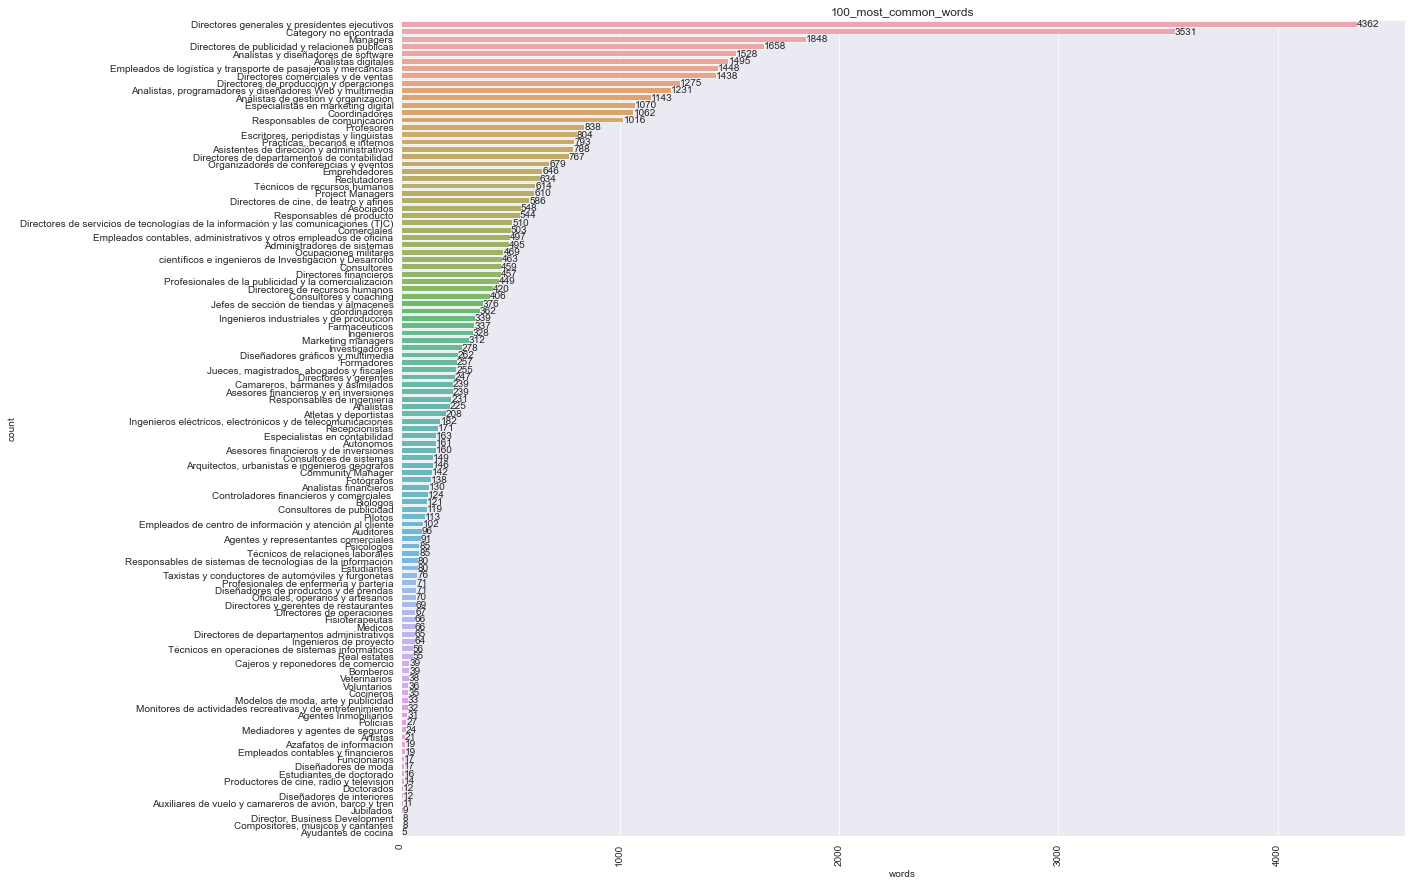

In [74]:
## Predictions
## =================================================================================================== ##

categories = unknown_category['job_category'].value_counts().values
jobs = unknown_category['job_category'].value_counts().index

plt.figure(figsize=(18, 15))
ax=sns.barplot(
    x=categories,
    y=jobs,
    alpha=0.8
)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90, fontsize=10)
plt.title('100_most_common_words')
plt.xlabel('words')
plt.ylabel('count');

Save data

In [69]:
unknown_category.to_csv('database/unknown_category.csv', sep=';', encoding='utf-8-sig')

In [78]:
count = unknown_category['job_category'].value_counts().shape[0]
print(f' Número de categorías encontradas: {count}')

 Número de categorías encontradas: 111


## 7. Dataset Ratings

Temporary dataset until final one is finish

In [59]:
# Data

experiences = pd.read_csv('database/experiences_category.csv', sep=';', encoding='utf-8-sig').drop(['Unnamed: 0', 'count'], axis=1)
experiences['job_description_short'] = experiences['job_description_short'].apply(lambda x: eval(x) if not isinstance(x, float) else x)
experiences = experiences[['user', 'job_category', 'months']].dropna(subset=['job_category', 'months'])
experiences

,user,job_category,months
35,607891d93f739f2a3ebe8501,Fisioterapeutas,11.0
36,607891d93f739f2a3ebe8501,Fisioterapeutas,1.0
38,616e7edb359c411d19857cc4,Fisioterapeutas,11.0
39,616e7edb359c411d19857cc4,Fisioterapeutas,1.0
40,616e913111b4ce2cba27a04e,Fisioterapeutas,11.0
...,...,...,...
75739,616e87ff359c411d19857f83,Profesores,15.0
75744,6183c4a4f691c71d402c44f8,"Escritores, periodistas y lingüistas",3.0
75745,6183c804f691c71d402c4792,Reclutadores,8.0
75757,61842b217cc1730b800a7cc9,Emprendedores,12.0


We realized certain fault on data definition such as the experience `start` and `end` time. To fix this, we'll consider `negative months` and `0` months as `6 months`.

* `months 0`: start: 2012 end 2012 -> months = 0
* `negative months`: start: 4/2012 end: 2012 -> months = -4

In [60]:
def duration(months):
    if months == 0 or months <0:
        return 6
    else:
        return months

experiences['months'] = experiences['months'].apply(duration)
experiences

,user,job_category,months
35,607891d93f739f2a3ebe8501,Fisioterapeutas,11.0
36,607891d93f739f2a3ebe8501,Fisioterapeutas,1.0
38,616e7edb359c411d19857cc4,Fisioterapeutas,11.0
39,616e7edb359c411d19857cc4,Fisioterapeutas,1.0
40,616e913111b4ce2cba27a04e,Fisioterapeutas,11.0
...,...,...,...
75739,616e87ff359c411d19857f83,Profesores,15.0
75744,6183c4a4f691c71d402c44f8,"Escritores, periodistas y lingüistas",3.0
75745,6183c804f691c71d402c4792,Reclutadores,8.0
75757,61842b217cc1730b800a7cc9,Emprendedores,12.0


We need to make sure each user doesn't have repeated `job_categories`, to do so we'll procced to group them by categories.
Finally a slight adjustiment on months definitions. Since there are users who have defined as experiences the different projects carried out the time spent at such proffesional sector doesn't make sense, therefore, we'll consider the `maximun time` spent at any single sector instead of the sum. 

In [73]:
def rating(months):
    if months['sum'] > 540:
        return months['max']
    else:
        return months['sum']
    
ratings = experiences.groupby(['user', 'job_category']) \
    .agg(['count', 'sum', 'max']) \
    .reset_index()

ratings['rating'] = ratings.apply(lambda row: rating(row['months']), axis=1)

ratings = ratings[['user', 'job_category', 'rating']] \
    .rename(columns = {'user':'userId', 'job_category':'jobId'}) \
    .sort_values(by='rating', ascending=False) \
    .droplevel(level=1, axis=1)

ratings

,userId,jobId,rating
13103,61840c9a9d8b4d05b8d8c4b2,Empleados de logística y transporte de pasajer...,698.0
12469,6183f706a64e303a84aa1770,Directores generales y presidentes ejecutivos,662.0
12457,6183f6e7a64e303a84aa175a,Emprendedores,651.0
10894,6183cf5cf691c71d402c4c2e,Ingenieros industriales y de producción,650.0
17673,618505945d32022d581048c6,Emprendedores,626.0
...,...,...,...
6134,60799e07bec58756ba89fd3f,"Directores de cine, de teatro y afines",1.0
8467,616e955011b4ce2cba27a134,Asistentes de dirección y administrativos,1.0
11408,6183d39ef691c71d402c4efc,Profesores,1.0
898,607817e888c498283227b819,Formadores,1.0


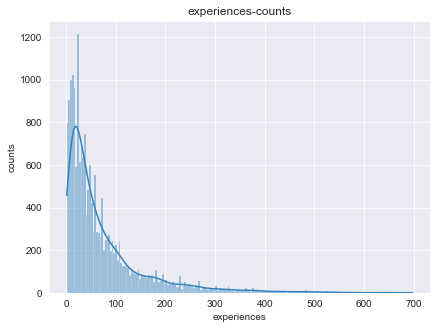

In [74]:
n_bins = 200

plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.histplot(data=ratings['rating'], bins=n_bins, color="#3182bd", kde=True)
plt.title('experiences-counts')
plt.xlabel('experiences')
plt.ylabel('counts');
#plt.ylim(0, 32);

In [75]:
#percentiles 25/50/75 & median
per_25 = np.percentile(ratings['rating'].dropna(), 25)
per_50 = np.percentile(ratings['rating'].dropna(), 50)
per_75 = np.percentile(ratings['rating'].dropna(), 75)
per_95 = np.percentile(ratings['rating'].dropna(), 95)
median = ratings['rating'].median()

print(f'Percentile 25%: {per_25/12:.0f} años.') 
print(f'Percentile 50%: {per_50/12:.0f} años.') 
print(f'Percentile 75%: {per_75/12:.0f} años.')
print(f'Percentile 95%: {per_95/12:.0f} años.')
print(f'The median is: {median/12:.0f} años.')

Percentile 25%: 2 años.
Percentile 50%: 4 años.
Percentile 75%: 8 años.
Percentile 95%: 21 años.
The median is: 4 años.


In [76]:
ratings.to_csv('database/ratings.csv', sep=';', encoding='utf-8-sig')

## 8. Requirements

In [4]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


## 7. Word Cloud

Just a touch of creativity

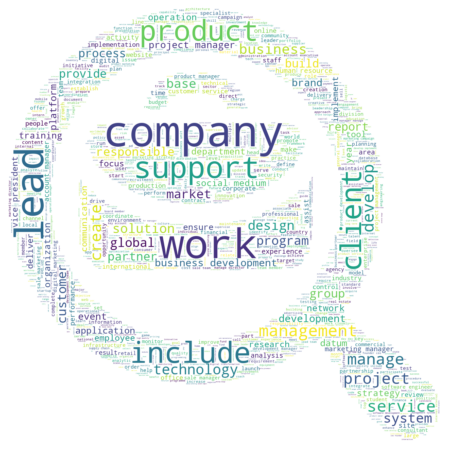

In [57]:
from wordcloud import WordCloud
from PIL import Image

mask = 'images/job_classifier_en.jpg'
alice_mask = np.array(Image.open(mask))

wc = WordCloud(background_color='white', max_words=2000, mask=alice_mask)

# generate word cloud
wc.generate(' '.join(words))

# show
plt.figure(figsize=(8, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
#plt.savefig('xxx.png')